# Na channels: current-voltage relationship (I-V)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [2]:
data_folder = "data/1-Na_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/1-Na_channels


['data/1-Na_channels/nav_inactivation_recovery -100mv.abf',
 'data/1-Na_channels/nav18-iv.abf',
 'data/1-Na_channels/nav18-ssinact.abf',
 'data/1-Na_channels/nav_inactivation_recovery -80mv_3.abf',
 'data/1-Na_channels/nav_inactivation_recovery -120mv_3.abf',
 'data/1-Na_channels/nav18-nav_recovery.abf',
 'data/1-Na_channels/nav_inactivation_3.abf',
 'data/1-Na_channels/nav_inactivation_2.abf',
 'data/1-Na_channels/nav_inactivation_1.abf',
 'data/1-Na_channels/nav_activation_2.abf',
 'data/1-Na_channels/nav_activation_3.abf',
 'data/1-Na_channels/nav_activation_1.abf',
 'data/1-Na_channels/nav_inactivation_recovery_2.abf']

Choose which file you want to analyze and copy/paste the file name here:

In [5]:
# data_file = 'data/1-Na_channels/nav18-iv.abf'
data_file = 'data/1-Na_channels/nav_activation_1.abf'

Now we can load the file and plot the raw data:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

Trace('nav_activation_1.abf')
Number of sweeps: 10
Points per sweep: 1,600
Duration per sweep: 0.160 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


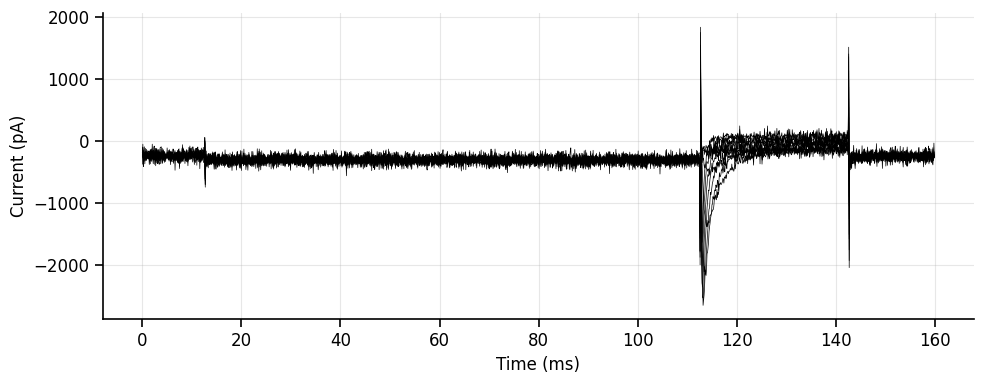

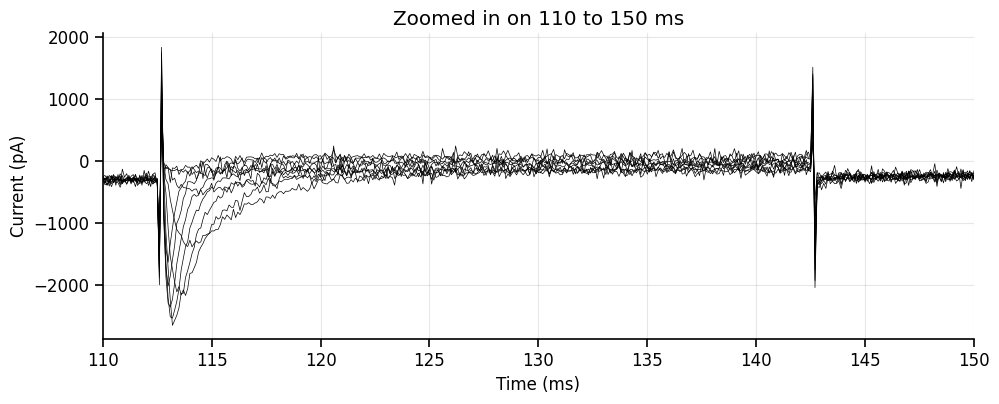

In [16]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=False,
                              units=['pA', 'mV'])
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)
x_axis_range = (110,150) # Here you can set the rage of the x-axis to 'zoom in' on a specific part of the trace (1-2s recommended)

# ----------------------------------------------------------------------------------------------------------------
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
plt.show()
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]} to {x_axis_range[1]} {time_units}')
plt.show()

## 2. Signal processing

### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [17]:
apply_filtering = False

You can run this next cell as many times as you want to fine-tune the filtering parameters:

In [18]:
if apply_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

    # Step 4: Highpass filter (removes low-frequency oscillations)
    # ------------------------------------------------------------
    # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # ------------------------------------------------------------

    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False)
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False)
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [19]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True
start_baseline = 0
end_baseline = 0.1

BASELINE SUBTRACTED:
Baseline currents: [-61.4624 -76.8433 -83.5571 ... -63.1104 -65.7959 -70.1904]


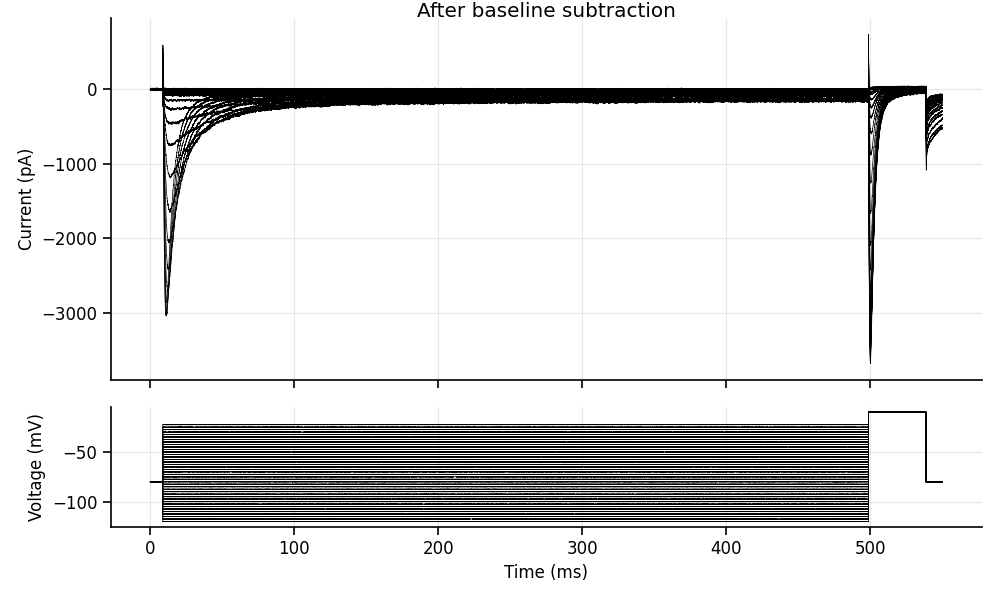

In [ ]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'current')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


## 3. Select what you want to measure

### 3.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

In [ ]:
# The start/end time just helps to zoom in on the traces.
start_time = 0
end_time = None

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 1.1
marker_2 = 6.
time_units = 'ms'

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(start_time,end_time)
ax2.set_xlim(start_time,end_time)
plt.show()

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

In [ ]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

current_steps, voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                                       measurement_type=measurement_type, time_units=time_units)

if np.all(voltage_steps == voltage_steps[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")
%matplotlib inline
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.35,0.6))
plt.show()

### 3.3. Optional: fit a line to the I-V points

If our data is noisy, we can get an estimate of the reversal potential by fitting a line to the data and finding where it intersects the x-axis.

The slope of the line will also give us an estimate of the conductance.

In [ ]:
# Choose which range of point you want to fit a line to
# Here it is important to select a range of points in the "linear" (right) part of the IV curve, where the Na channels are open.
# (We will use this line to figure out the reversal potential)
voltage_start = -10
voltage_end = +30


# -----------------------------------------------------------------------------------------------------------------------
assert voltage_start < voltage_end, "voltage_start must be less than voltage_end"
assert voltage_start < np.max(voltage_steps), "voltage_start must be less than the largest voltage step"
assert voltage_end > np.min(voltage_steps), "voltage_end must be greater than the smallest voltage step"

# Sort voltage steps in ascending order
voltage_steps, sort_idx = np.sort(voltage_steps), np.argsort(voltage_steps)
current_steps = current_steps[sort_idx]

# Convert voltage start/end to index
points_start = np.where(np.round(voltage_steps) >= voltage_start)[0][0]
points_end = np.where(np.round(voltage_steps) <= voltage_end)[0][-1] +1

# Fit a line to the points
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.4), ylabel_coords=(0.6,0.7))
from scipy.stats import linregress
voltage_steps_to_fit = voltage_steps[points_start:points_end]
current_steps_to_fit = current_steps[points_start:points_end]
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps_to_fit, current_steps_to_fit)
fit_line = slope * voltage_steps + intercept
ax.plot(voltage_steps_to_fit, fit_line[points_start:points_end], linestyle='--', color='r', label='Fit', linewidth=2)
ax.set_ylim(bottom=np.min(current_steps)*1.5)

print(f"G = slope = {slope:.3f} nS")
print(f"Resistance = 1/slope = {1/slope * 1000:.3f} MOhm")

# Find the intercept on the x-axis (where current is zero) to get E_rev (reversal potential)
E_rev = -intercept / slope
ax.scatter(voltage_steps[points_start], fit_line[points_start], color='r', zorder=5)
ax.scatter(voltage_steps[points_end-1], fit_line[points_end-1], color='r', zorder=5)
ax.scatter(E_rev, 0, color='b', zorder=5)
ylim = ax.get_ylim()
ax.annotate("E_rev \n(from line fit)", xy=(E_rev, 0), xytext=(E_rev, ylim[0]), color='b',
            arrowprops=dict(arrowstyle="->", mutation_scale=20, linewidth=2, color='blue'))
print(f"Reversal potential: {E_rev:.3f} mV")
plt.show()

# Check if the line is a good fit
if r_value**2 < 0.95:
    print(f"**WARNING: The line is a BAD fit**, r^2 = {r_value**2:.4f}")

Before running the next code cell, make sure that the line fit is good and gives an accurate measure of the reversal potential (E_rev). 

Otherwise your Na channel activation curve will be bad.

### 3.4. Optional: Calculate the channel activation curve 

<img src="images/Na_IV_activation_analysis.png" width="800">


Here we are channel activation by calculating the conductance of the channel at different voltages and normalizing against the maximum conductance.

In [ ]:
# Calculate the conductance at each point
G = current_steps / (voltage_steps - E_rev)

# We are estimating the G from single points, so errors will be larger close to the 
# reversal potential (where our calculation is very sensitive to small variations in V-E_rev).

# Remove the points within 5mv of the reversal potential
# (since the conductance is not well defined at the reversal potential)
delta_V = voltage_steps - E_rev
mask = np.abs(delta_V) > 5
voltage_steps = voltage_steps[mask]
current_steps = current_steps[mask]
G = G[mask]

# Plot the conductance
%matplotlib inline
fig = plt.figure()
plt.plot(voltage_steps, G, 'o', color='black')
plt.xlabel('Voltage (mV)')
plt.ylabel('Conductance (nS)')
plt.show()

In [ ]:
# # Now we normalize these conductances by the maximum value, i.e. the fully open channel conductance
G_max = np.max(G) 

# # Sometime the Gmax measurement is a bit noisy, so can instead normalize against the average of the last 5 points
# G_max = np.mean(G[-5:]) 

# # Alternatively, we can use the line we fit above. 
# # If we fit the line correctly (around the E_rev), the slope of that line is the maximum conductance
# G_max = slope

# Now we normalize the conductances by the maximum value
G_norm = G / G_max

# --------------------------------------------------------------------------------------------------------------------
# Finally we can fit the Boltzmann function (sigmoidal curve) to the data 
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))

from scipy.optimize import curve_fit
k_guess = 5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, G_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
G_fit = boltzmann(V_fit, V_half_fit, k_fit)

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, G_norm, 'o', label='Data', color='black')
ax.plot(V_fit, G_fit, '-', label='Boltzmann fit', color='red')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized Conductance (G/Gmax)')
ax.set_title('NaV Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()